In [1]:
import numpy as np
from imageio import imread
from os import listdir
from os.path import isdir, join
import matplotlib
from matplotlib import pyplot as plt

In [12]:
matplotlib.rc('figure', figsize=(10, 10))

In [3]:
base_dir = 'orl-faces'
w, h = 112, 92

In [4]:
def plot_images(images, cols=3, cmap='gray'):
    rows = (len(images) + cols - 1) / cols
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap=cmap)
    plt.show()

In [5]:
def read_data():
    """
    Reads data from the directory. Take first 5 images as train and the rest as test.
    The returned xtrain and xtest are of shape (size x dimension)
    """
    xtrain, ytrain = np.empty((0, w*h), dtype=np.float32), np.array([])
    xtest, ytest = np.empty((0, w*h), dtype=np.float32), np.array([])
    
    subject_list = [s for s in listdir(base_dir) if isdir(join(base_dir, s))]
    
    for s in subject_list:
        image_paths = [join(base_dir, s, str(i) + '.pgm') for i in range(1, 11)]
        xtrain = np.vstack((xtrain, [imread(ipath).flatten() for ipath in image_paths[:5]]))
        xtest = np.vstack((xtest, [imread(ipath).flatten() for ipath in image_paths[5:]]))
        ytrain = np.append(ytrain, [s]*5)
        ytest = np.append(ytest, [s]*5)
    return xtrain, ytrain, xtest, ytest

In [6]:
def largest_eigs(A, k):
    """
    Returns the k largest eigenvalues and k largest eigenvectors (in colum form) of a matrix A
    Input:
        A: a square matrix
        k: number of top components
    Output:
        kvals: array of k largest eigenvalues
        kvects: array of dimension (dim(A), k) representing the top k eigenvectors
    """
    eig, veig = np.linalg.eig(A.astype(np.float32))
    keig, kveig = zip(*sorted(zip(eig, veig.T), key=lambda x: x[0], reverse=True)[:k])
    keig, kveig = np.asarray(keig), np.asarray(kveig).T
    return keig, kveig

In [7]:
def get_U(X, k):
    """
    Returns a matrix U, such that U.T * X is a lower representation of X and U * U.T * X
    is the recovered version of X
    Input:
        X: a (m x d) matrix where m is the number of points and d is the dimension
        k: number of components to use
    Output: U
    """
    assert(k <= min(X.shape[0], X.shape[1]))
    B = np.matmul(X, X.T)
    _, V = largest_eigs(B, k)
    U = np.matmul(X.T, V)
    U = U / np.linalg.norm(U, axis=0) # normalize every column
    return U

In [8]:
xtrain, ytrain, xtest, ytest = read_data()

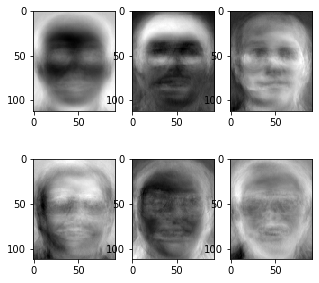

In [9]:
# Question 1
def plot_top_k_components(k):
    U = get_U(xtrain, k)
    top_k_components = np.reshape(U.T, (k, w, h))
    plot_images(top_k_components)

plot_top_k_components(6)

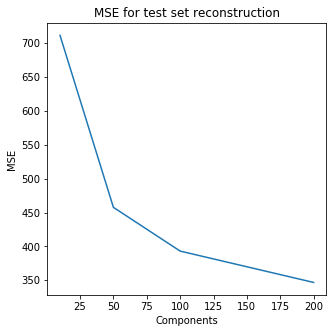

In [10]:
# Question 2
def face_reconstruction(klist, X):
    mse = []
    for k in klist:
        U = get_U(xtrain, k)
        Xr = np.matmul(U, np.matmul(U.T, X.T)).T
        mse.append(np.mean(np.square(Xr - X)))
    plt.plot(klist, mse)
    plt.xlabel('Components')
    plt.ylabel('MSE')
    plt.title('MSE for test set reconstruction')
    #plt.savefig('mse.jpg')
    plt.show()

klist = [10, 50, 100, 200]
face_reconstruction(klist, xtest)

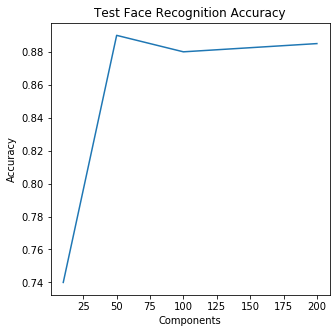

In [11]:
# Question 3
def face_recognition(klist):
    acc = []
    for k in klist:
        accuracy = 0
        U = get_U(xtrain, k)
        Xr = np.matmul(U, np.matmul(U.T, xtest.T)).T
        for i, xr in enumerate(Xr):
            j = np.argmin(np.linalg.norm(xr - xtrain, axis=1))
            if ytest[i] == ytrain[j]:
                accuracy += 1
        acc.append(accuracy / xtest.shape[0])
    plt.plot(klist, acc)
    plt.xlabel('Components')
    plt.ylabel('Accuracy')
    plt.title('Test Face Recognition Accuracy')
    #plt.savefig('face_recog_acc.jpg')
    plt.show()

klist = [10, 50, 100, 200]
face_recognition(klist)

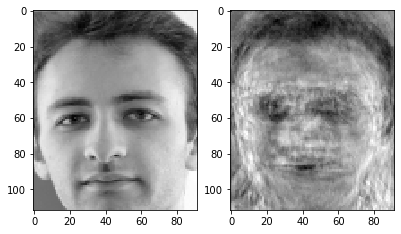

MSE: 2568.7336


In [13]:
# Question 4
def test_random_face(where=xtrain):
    x = where if len(where.shape) == 1 else where[np.random.randint(0, where.shape[0] - 1)]
    U = get_U(xtrain, 200)
    xr = np.matmul(U, np.matmul(U.T, x.T)).T
    plot_images([np.reshape(x, (w, h)), np.reshape(xr, (w, h))])
    print('MSE:', np.linalg.norm(x-xr))

me = imread('../images/pca/me.jpg')[:, :, 0].flatten().astype(np.float32)
test_random_face(me)